Found 450 peaks in moving variance


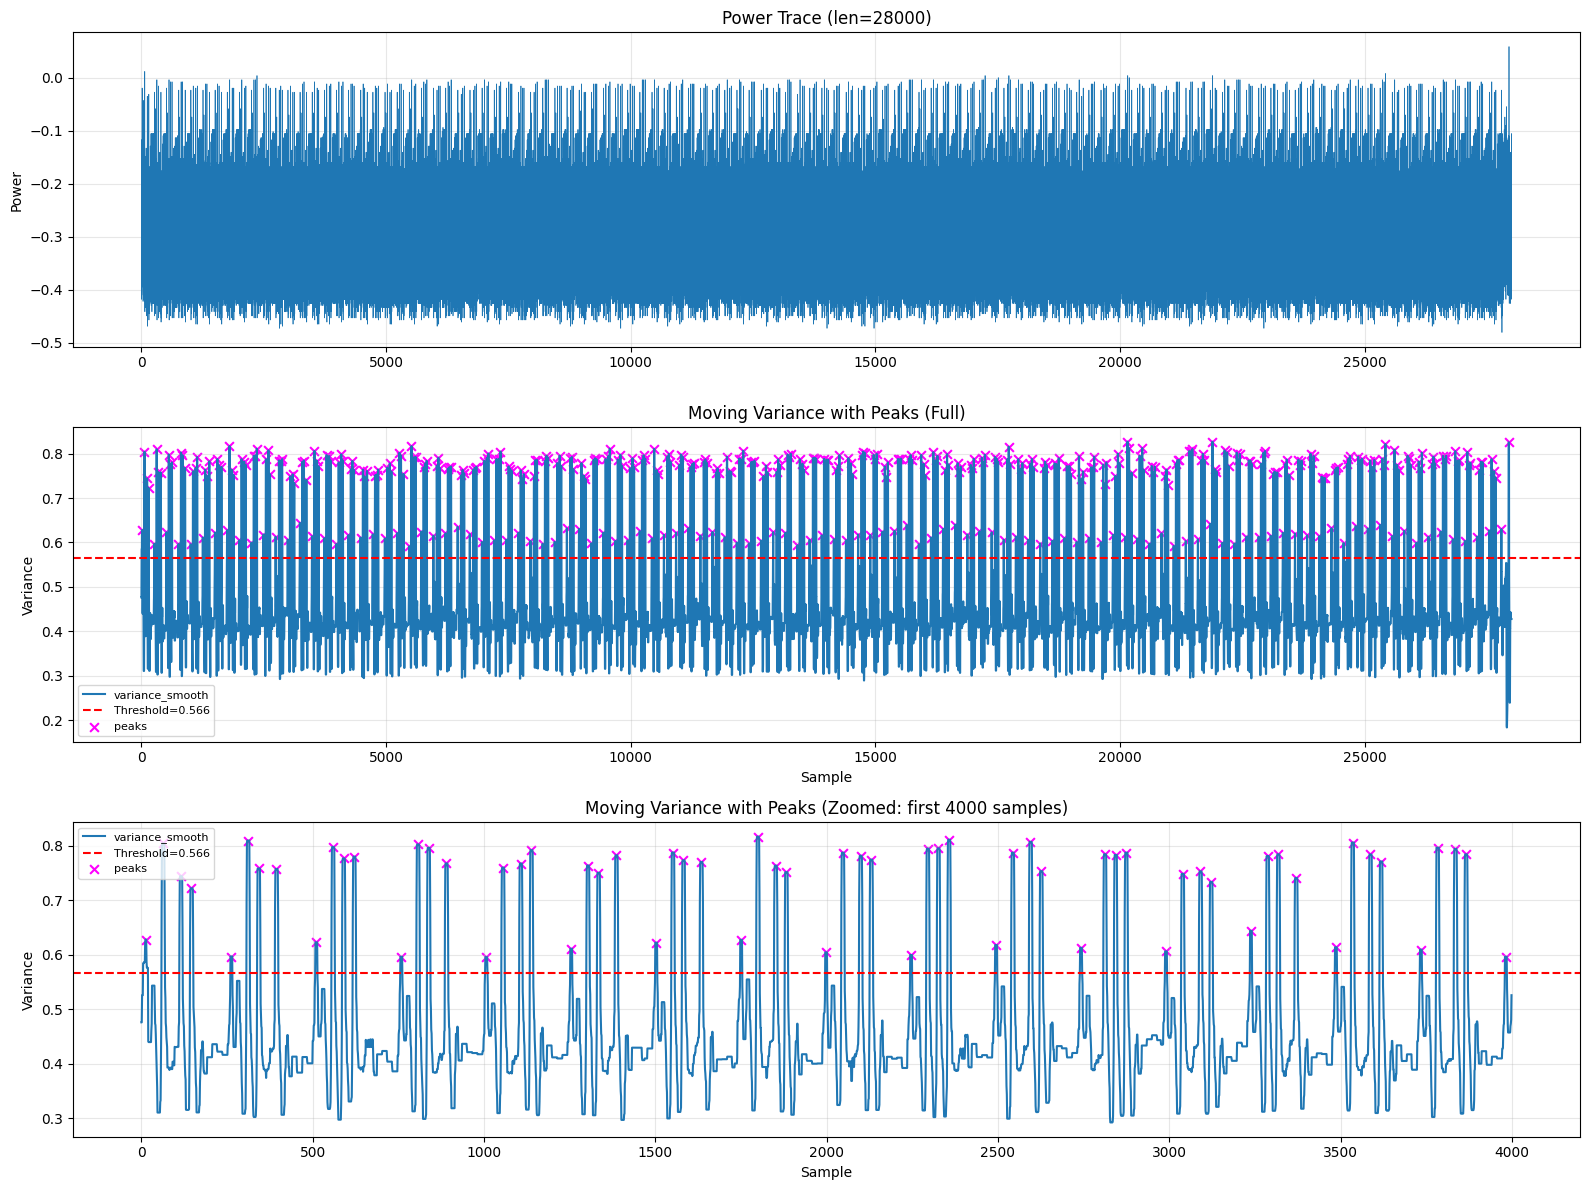

Relative peaks (grouped by 4): [  0  50 102 133   0  50  81 132   0  49  80 111   0  49  80 132   0  49
 101 132   0  49  80 132   0  49  80 132   0  49 101 132   0  49 101 132
   0  49  80 111   0  49 101 132   0  70 102 133   0  49 101 132   0  49
  80 132   0  50 101 132   0  50 101 132   0  49 101 132   0  49  80 111
   0  49  80 132   0  49  80 111   0  49 101 132   0  50  80 132   0  49
 101 132   0  49  80 111   0  70 101 132   0  49  80 111   0  70 101 132
   0  70 101 132   0  49 101 132   0  49 101 132   0  49  80 111   0  49
  80 111   0  70 101 132   0  49  80 111   0  49 101 132   0  70 101 132
   0  49 101 132   0  49  80 111   0  49 101 132   0  49 101 132   0  49
 101 132   0  49  80 111   0  49 101 132   0  70 101 132   0  70 101 132
   0  49  80 111   0  70 101 132   0  70 101 132   0  49 101 132   0  49
  81 132   0  49  80 111   0  49 101 132   0  70 101 132   0  49  80 111
   0  49 101 132   0  70 101 132   0  49 102 132   0  49  80 111   0  49
 101 132   0  70 101

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from scipy.signal import find_peaks

def analyze_trace_and_relative_peaks(trace,
                                     window_size=10,
                                     smooth_size=14,
                                     threshold_percentile=85.45):
    trace = np.array(trace)
    n = len(trace)

    if window_size >= n:
        window_size_local = max(10, n // 10)
    else:
        window_size_local = window_size

    variance = np.array([
        np.var(trace[i:i + window_size_local])
        for i in range(n - window_size_local)
    ])
    variance = np.pad(variance, (0, window_size_local), mode='edge')

    vmin, vmax = np.min(variance), np.max(variance)
    if vmax > vmin:
        variance_norm = (variance - vmin) / (vmax - vmin)
    else:
        variance_norm = np.zeros_like(variance)

    if smooth_size < 1:
        smooth_size = 1
    if smooth_size % 2 == 0:
        smooth_size += 1

    variance_smooth = median_filter(variance_norm, size=smooth_size)

    threshold = np.percentile(variance_smooth, threshold_percentile)

    peak_indices, peak_props = find_peaks(variance_smooth, height=threshold)
    print(f"Found {len(peak_indices)} peaks in moving variance")

    peak_indices_rel = peak_indices.copy()
    for i in range(0, len(peak_indices_rel), 4):
        group = peak_indices_rel[i:i+4]
        if len(group) == 0:
            continue
        base = group[0]
        peak_indices_rel[i:i+4] = group - base

    plt.figure(figsize=(16, 12))

    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(trace, linewidth=0.5)
    ax1.set_title(f'Power Trace (len={len(trace)})')
    ax1.set_ylabel('Power')
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(3, 1, 2)
    ax2.plot(variance_smooth, label='variance_smooth')
    ax2.axhline(y=threshold, color='r', linestyle='--',
                label=f'Threshold={threshold:.3f}')
    ax2.scatter(peak_indices, variance_smooth[peak_indices],
                color='magenta', marker='x', s=40, label='peaks')
    ax2.set_title('Moving Variance with Peaks (Full)')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Variance')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(3, 1, 3)
    zoom_end = min(4000, len(variance_smooth))
    zoom_mask = np.arange(zoom_end)

    ax3.plot(variance_smooth[:zoom_end], label='variance_smooth')

    ax3.axhline(y=threshold, color='r', linestyle='--',
                label=f'Threshold={threshold:.3f}')

    zoom_peaks = peak_indices[peak_indices < zoom_end]
    ax3.scatter(zoom_peaks, variance_smooth[zoom_peaks],
                color='magenta', marker='x', s=40, label='peaks')

    ax3.set_title('Moving Variance with Peaks (Zoomed: first 4000 samples)')
    ax3.set_xlabel('Sample')
    ax3.set_ylabel('Variance')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return peak_indices_rel

rel_peaks = analyze_trace_and_relative_peaks(np.load("/home/haard/Documents/recruitment/haard_phase2/niteCTF/upsolve_hw/middle_fingers_trace.npy"))
print("Relative peaks (grouped by 4):", rel_peaks)


In [7]:
def classify_groups(arr, error_margin_a=10, error_margin_bc=10):
    
    case_to_binary = {
        'A': '00',
        'B': '01',
        'C': '10',
        'D': '11'
    }
    results = []
    
    for i in range(0, len(arr), 4):
        group = arr[i:i+4]
        
        if len(group) != 4:
            print(f"Skipping incomplete group: {group}")
            continue
        
        e1, e2, e3, e4 = group
        
        diff_1_2 = abs(e2 - e1)
        diff_2_3 = abs(e3 - e2)
        diff_3_4 = abs(e4 - e3)
        
        case = 'D'
        
        if abs(diff_1_2 - 70) <= error_margin_a:
            case = 'A'
        elif abs(diff_2_3 - 50) <= error_margin_bc:
            case = 'B'
        elif abs(diff_3_4 - 50) <= error_margin_bc:
            case = 'C'
        
        results.append({
            'group': group,
            'case': case,
            'binary': case_to_binary[case],
            'diffs': {
                '1-2': diff_1_2,
                '2-3': diff_2_3,
                '3-4': diff_3_4
            }
        })
    
    binary_string = ''.join([r['binary'] for r in results])
    ascii_message = binary_to_ascii(binary_string)
    
    return results, binary_string, ascii_message


def binary_to_ascii(binary_string):
    ascii_chars = []
    
    for i in range(0, len(binary_string), 8):
        byte = binary_string[i:i+8]
        if len(byte) == 8:
            ascii_value = int(byte, 2)
            ascii_chars.append(chr(ascii_value))
    
    return ''.join(ascii_chars)

results, binary_string, ascii_message = classify_groups(rel_peaks)

print("Classification Results:")
print("=" * 60)
for idx, result in enumerate(results, 1):
    print(f"\nGroup {idx}: {result['group']}")
    print(f"  Case: {result['case']} → Binary: {result['binary']}")
    print(f"  Differences: 1-2={result['diffs']['1-2']}, "
          f"2-3={result['diffs']['2-3']}, 3-4={result['diffs']['3-4']}")

print("\n" + "=" * 60)
print(f"\nFull Binary String: {binary_string}")
print(f"Binary Length: {len(binary_string)} bits")
print(f"\nDecoded ASCII Message: '{ascii_message}'")

Skipping incomplete group: [  0 154]
Classification Results:

Group 1: [  0  50 102 133]
  Case: B → Binary: 01
  Differences: 1-2=50, 2-3=52, 3-4=31

Group 2: [  0  50  81 132]
  Case: C → Binary: 10
  Differences: 1-2=50, 2-3=31, 3-4=51

Group 3: [  0  49  80 111]
  Case: D → Binary: 11
  Differences: 1-2=49, 2-3=31, 3-4=31

Group 4: [  0  49  80 132]
  Case: C → Binary: 10
  Differences: 1-2=49, 2-3=31, 3-4=52

Group 5: [  0  49 101 132]
  Case: B → Binary: 01
  Differences: 1-2=49, 2-3=52, 3-4=31

Group 6: [  0  49  80 132]
  Case: C → Binary: 10
  Differences: 1-2=49, 2-3=31, 3-4=52

Group 7: [  0  49  80 132]
  Case: C → Binary: 10
  Differences: 1-2=49, 2-3=31, 3-4=52

Group 8: [  0  49 101 132]
  Case: B → Binary: 01
  Differences: 1-2=49, 2-3=52, 3-4=31

Group 9: [  0  49 101 132]
  Case: B → Binary: 01
  Differences: 1-2=49, 2-3=52, 3-4=31

Group 10: [  0  49  80 111]
  Case: D → Binary: 11
  Differences: 1-2=49, 2-3=31, 3-4=31

Group 11: [  0  49 101 132]
  Case: B → Binary: